# Why ``analphipy``

`analphipy` is a python package for common analysis on pair potentials.  It's features include

* Simple interface for defining a pair potential
* Methods to create 'cut', 'linear force shifted', and 'table' potentials
* Calculation of common metrics, like the second virial coefficient, and Noro-Frenkel effective parameters

This package is used actively by the author, so new metrics and potentials will be added over time.  If you have a suggestion, please let the author know!

## Useful references

Please see the following for a primer on the type of analysis provided in `analphipy`.

* [M.G. Noro and D. Frenkel (2000), "Extended corresponding-states behavior for particles with variable range attractions". Journal of Chemical Physics, 113, 2941.](https://pubs.aip.org/aip/jcp/article/113/8/2941/450041/Extended-corresponding-states-behavior-for)
* [J.A. Barker and D. Henderson (1976), "What Is Liquid? Understanding the States of Matter". Reviews of Modern Physics, 48, 587-671.](https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.48.587)
* [J.D. Weeks, D. Chandler and H.C. Andersen (1971), "Role of Repulsive Forces in Determining the Equilibrium Structure of Simple Liquids", Journal of Chemical Physics 54, 5237-5247](https://pubs.aip.org/aip/jcp/article/54/12/5237/85492/Role-of-Repulsive-Forces-in-Determining-the)



# A simple example

Let's take a look at the properties of a [Lennard-Jones](https://en.wikipedia.org/wiki/Lennard-Jones_potential) (LJ), which has a length scale $\sigma$ and energy scale $\epsilon$.  It is typical to consider units of length in terms of $\sigma$ and energy in terms of $\epsilon$, which is the same as setting $\sigma=1$ and $\epsilon=1$.  We create a LJ potential object using the following:

In [1]:
# the passed function should only be a function of r, so use partial
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import analphipy

p = analphipy.potential.LennardJones(sig=1.0, eps=1.0)

In [2]:
p.r_min

1.122462048309373

In [3]:
p.to_measures()

:::{eval-rst}
.. currentmodule:: analphipy.potential
:::

This defines an LJ potential.  This contains things like the potential energy function {meth}`LennardJones.phi`, the derivative function {meth}`LennardJones.dphidr`, the location of the minimum in the potential {attr}`Analytic.r_min`, and the value at the minimum {attr}`Analytic.phi_min`. 
For example:

In [4]:
%matplotlib inline

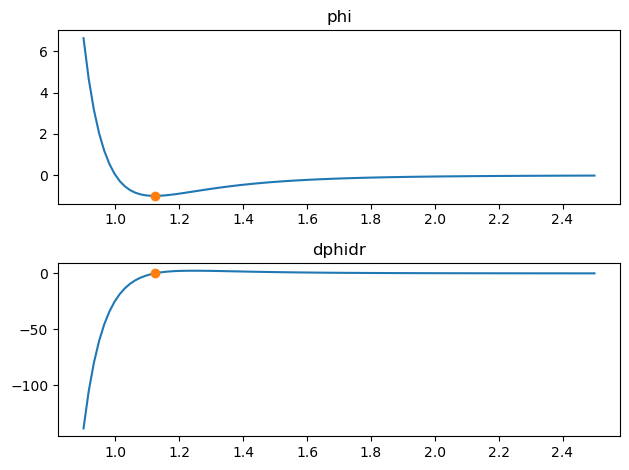

In [5]:
r = np.linspace(0.9, 2.5, 100)
fig, axes = plt.subplots(2)
axes[0].set_title("phi")
axes[0].plot(r, p.phi(r))

axes[0].plot(p.r_min, p.phi_min, marker="o")

axes[1].set_title("dphidr")
axes[1].plot(r, p.dphidr(r))
axes[1].plot(p.r_min, p.dphidr(p.r_min), marker="o")

fig.tight_layout()

A common question is, is the pair potential of interest like some other, perhaps simpler, potential? For example, 
Can given potential be mapped to some 'effective' hard-sphere or square-well potential?  There is a deep history to
this [question](http://www.sklogwiki.org/SklogWiki/index.php/Barker_and_Henderson_perturbation_theory). In brief, what is commonly done (and what ``analphipy`` is designed to do) is 

1. Determine an effective (temperature dependent) hard-sphere diameter
2. Determine an effective square-well well depth
3. Determine an effective square-well attractive range.

Please look at the above references for further information. To perform the analysis on our LJ potential, we first need to create a {class}`analphipy.norofrenkel.NoroFrenkelPair` object.  This is conveniently done with the following method.

In [6]:
nf = p.to_nf()

Now, the object `nf` can be used to calculate effective metrics.  For example, to calculate the effective hard-sphere diameter at an inverse temperature $\beta = 1/(k_{\rm B} T)$, where $k_{\rm B}$ is Boltzmann's constant, use the following:

In [7]:
nf.sig(beta=1.0)

1.0156054202252172

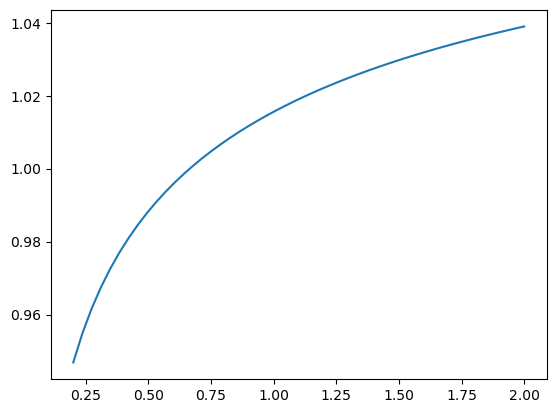

In [8]:
betas = np.linspace(0.2, 2.0)

plt.plot(betas, [nf.sig(beta) for beta in betas])

Likewise, the effective attractive range `lambda` can be found using

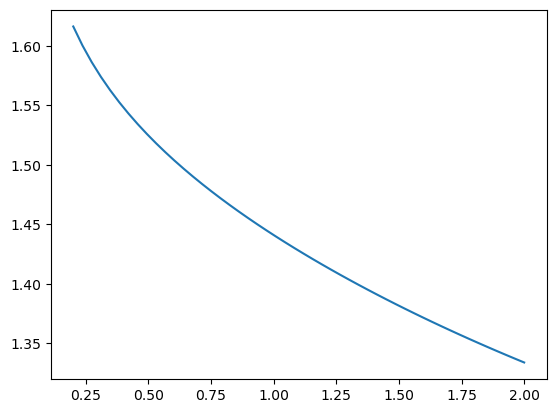

In [9]:
plt.plot(betas, [nf.lam(beta) for beta in betas])

Since it is common want to calculate such metrics over a spectrum of values of $\beta$, there is a utility method {meth}`~analphipy.norofrenkel.NoroFrenkelPair.table`.  This creates a dictionary of results, which can be easily converted to a pandas DataFrame

In [10]:
# create a dictionary of values
betas = np.linspace(0.2, 2.0, 4)
table = nf.table(betas=betas, props=["sig", "eps", "lam"])
table

{'beta': array([0.2, 0.8, 1.4, 2. ]),
 'sig': [0.9468474615554747,
  1.0072387682627164,
  1.0274539879239069,
  1.0389955732798468],
 'eps': [-1.0, -1.0, -1.0, -1.0],
 'lam': [1.6162246932413373,
  1.4699861479698415,
  1.3923506242906025,
  1.333901317192492]}

In [11]:
pd.DataFrame(table)

,beta,sig,eps,lam
0,0.2,0.946847,-1.0,1.616225
1,0.8,1.007239,-1.0,1.469986
2,1.4,1.027454,-1.0,1.392351
3,2.0,1.038996,-1.0,1.333901


:::{eval-rst}
.. currentmodule:: analphipy
:::
There are several more metrics, and potential energy functions included in the modules {mod}`analphipy.measures` and {mod}`analphipy.norofrenkel`.  Please look at the api reference for
further information!

# Defining your own potential

If you'd like to define your own potential energy function, there are two routes.  The easiest is the define a callable
potential energy function, and use {class}`analphipy.potential.Generic`.  For example, you can create a LJ potential using:

In [12]:
def my_lj_func(r, sig, eps):
    # function should always return an array
    r = np.asarray(r)
    x = sig / r

    return 4.0 * eps * (x**12 - x**6)


g = analphipy.potential.Generic(phi_func=partial(my_lj_func, sig=1.0, eps=1.0))
g

Generic(r_min=None, phi_min=None, segments=None, phi_func=functools.partial(<function my_lj_func at 0x19b71a520>, sig=1.0, eps=1.0), dphidr_func=None)

In [13]:
r = np.linspace(0.5, 2.5, 5)

g.phi(r) - p.phi(r)

array([ 0.00000000e+00,  0.00000000e+00,  5.55111512e-17,  0.00000000e+00,
       -3.46944695e-18])

Note that additional info is not required, but you can explicitly pass it if so desired.  For example, include a 
form for $d\phi(r)/dr$

In [14]:
def my_lj_deriv_func(r, sig, eps):
    r = np.asarray(r)
    x = sig / r

    return -48 * eps * (x**12 - 0.5 * x**6) / r


sig = 1.0
eps = 1.0
g = analphipy.potential.Generic(
    phi_func=partial(my_lj_func, sig=sig, eps=eps),
    dphidr_func=partial(my_lj_deriv_func, sig=1.0, eps=1.0),
    # infinte integration bounds
    segments=[0.0, np.inf],
)

In [15]:
g.dphidr(r) - p.dphidr(r)

array([ 0.00000000e+00,  0.00000000e+00, -2.22044605e-16,  0.00000000e+00,
        0.00000000e+00])

Note that to investigate the Noro-Frenkel metrics, the values of `r_min` and `segments` must be set.  The latter is the integration bounds including any discontinuities.  This was done analytically in {class}`analphipy.potential.LennardJones`, but is not set in {class}`analphipy.potential.Generic`.  You can pass a value directly during the creation, or set the value numerically.  For example, we could use:

In [16]:
# this will raise an error because we don't have a minimum
g.to_nf()

ValueError: must set `self.r_min` to use NoroFrenkel

In [17]:
# instead set the minimum numerically with the following
g_with_min = g.assign_min_numeric(
    r0=1.0,  # guess for location of minimum
    bounds=[0.5, 1.5],  # bounds for search
)

In [18]:
g_with_min.to_nf().lam(beta=1.5)

1.3815918477142934

In [19]:
p.to_nf().lam(beta=1.5)

1.3815918477142932

# Cut potential

The classes {mod}`analphipy.potential` module provides a simple means to 'cut' the potential.  To perform a simple cut, use the method {meth}`analphipy.base_potential.PhiBase.cut`.

In [20]:
p_cut = p.cut(2.5)

In [21]:
p_cut.phi(2.5)

array(0.)

In [22]:
p.phi(2.5)

-0.016316891136000003

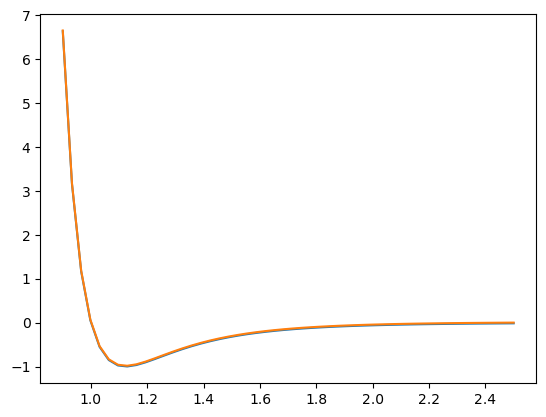

In [23]:
r = np.linspace(0.9, 2.5)
plt.plot(r, p.phi(r))
plt.plot(r, p_cut.phi(r))

To perform a cut with linear force shift, use the method {meth}`analphipy.base_potential.PhiBase.lfs`.

In [24]:
p_lfs = p.lfs(rcut=2.5)

In [25]:
p_lfs.phi(2.5)

array(0.)

In [26]:
p_lfs.dphidr(2.5)

array(0.)

In [27]:
p_cut.dphidr(2.5)

array(0.03899948)

In [28]:
p.dphidr(2.5)

0.03899947745280001

Note that to use the `lfs` method, `dphidr` of the class must be specified.

Please take a look at the api documentation for more information!